# Import Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import sys

# Load and Preprocess Data

In [3]:
# Suppress runtime warnings from division by zero, which we handle manually.
warnings.filterwarnings("ignore", category=RuntimeWarning)

try:
    df = pd.read_csv('standardized_shark_data_daily.csv')
    print("Successfully loaded 'shark_data.csv'.")
except FileNotFoundError:
    # If the file is not found, use dummy data for demonstration purposes
    print("Error: 'shark_data.csv' not found.")
    print("Please export your .numbers file to CSV and place it in the same directory.")
    print("--- Using dummy data for a demonstration run. ---")
    data = {'DeployID': ['Shark1'] * 20,
            'date': pd.to_datetime(['2023-01-01 12:00', '2023-01-01 13:00', '2023-01-01 14:00', '2023-01-01 15:00', '2023-01-01 16:00', '2023-01-01 17:00', '2023-01-01 18:00', '2023-01-01 19:00', '2023-01-01 20:00', '2023-01-01 21:00'] * 2),
            'latitude': [-34.0, -34.1, -34.2, -34.1, -34.0, -34.1, -34.2, -34.3, -34.2, -34.1, -34.0, -34.1, -34.2, -34.1, -34.0, -34.1, -34.2, -34.3, -34.2, -34.1],
            'longitude': [18.0, 18.1, 18.2, 18.1, 18.0, 18.1, 18.2, 18.3, 18.2, 18.1, 18.0, 18.1, 18.2, 18.1, 18.0, 18.1, 18.2, 18.3, 18.2, 18.1]}
    df = pd.DataFrame(data)

# Clean column names to prevent KeyErrors by stripping whitespace and converting to lowercase.
df.columns = df.columns.str.strip().str.lower()

# Add validation step for required columns
required_columns = ['date', 'deployid', 'latitude', 'longitude']
available_columns = df.columns.tolist()
missing_columns = [col for col in required_columns if col not in available_columns]

if missing_columns:
    print(f"\nCRITICAL ERROR: The following required columns are missing: {missing_columns}")
    print(f"The available columns in your file are: {available_columns}")
    print("Please check your 'shark_data.csv' file and correct the column names.")
    sys.exit() # Stop the script if columns are missing

print("\nCleaned column names:", df.columns.tolist())

# 1. Replace commas with periods to ensure correct decimal format.
# 2. Convert to numeric, coercing any errors into 'Not a Number' (NaN).
for col in ['latitude', 'longitude']:
    df[col] = df[col].astype(str).str.replace(',', '.')
    df[col] = pd.to_numeric(df[col], errors='coerce')

# 3. Drop any rows where the conversion to a number failed.
df.dropna(subset=['latitude', 'longitude'], inplace=True)
print(f"Data cleaned. Remaining data points: {len(df)}")


# Ensure the 'date' column is correctly formatted and sort the data
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(by=['deployid', 'date']).reset_index(drop=True)



Successfully loaded 'shark_data.csv'.

Cleaned column names: ['date', 'latitude', 'longitude', 'area_tagged', 'sex', 'maturity', 'deployid']
Data cleaned. Remaining data points: 4752


In [4]:
df

,date,latitude,longitude,area_tagged,sex,maturity,deployid
0,2012-05-11,-33.889750,23.54125,Gansbaai,M,Juvenile,Albert
1,2012-05-12,-34.386000,21.04200,Gansbaai,M,Juvenile,Albert
2,2012-05-13,-34.365333,21.76150,Gansbaai,M,Juvenile,Albert
3,2012-05-14,-34.173250,22.17750,Gansbaai,M,Juvenile,Albert
4,2012-05-15,-34.148000,22.12600,Gansbaai,M,Juvenile,Albert
...,...,...,...,...,...,...,...
4747,2013-09-25,-34.584500,19.25950,Gansbaai,F,Sub_adult,Vindication
4748,2013-09-29,-34.463000,19.31900,Gansbaai,F,Sub_adult,Vindication
4749,2013-09-30,-34.470500,19.34500,Gansbaai,F,Sub_adult,Vindication
4750,2013-10-25,-34.421000,20.13600,Gansbaai,F,Sub_adult,Vindication


In [5]:
print(df['maturity'].unique())

['Juvenile' 'Sub_adult' 'Adult']


# Grid Formation

To analyze continuous GPS data, we first discretize the geographical area into a finite number of states. This is achieved by overlaying an N×N grid. Each cell in this grid represents a unique state.

In [7]:
# Set the resolution of the grid. Higher numbers mean more, smaller cells.
# INPUT PARAMETERS HERE
GRID_SIZE = 20
NUM_STATES = GRID_SIZE * GRID_SIZE

# Determine the geographical boundaries from the data
min_lat, max_lat = df['latitude'].min(), df['latitude'].max()
min_lon, max_lon = df['longitude'].min(), df['longitude'].max()

# Calculate the dimensions of a single grid cell
lat_step = (max_lat - min_lat) / GRID_SIZE if (max_lat - min_lat) > 0 else 1
lon_step = (max_lon - min_lon) / GRID_SIZE if (max_lon - min_lon) > 0 else 1




# State Definition

A state ID is calculated from its grid position (row, column) using the formula:

$$ \text{State ID} = (\text{row} \times N) + \text{col} $$

Where row and col are zero-indexed.

In [8]:
def get_state(lat, lon, min_lat, min_lon, lat_step, lon_step, grid_size):
    """Maps a latitude and longitude to a specific state (grid cell ID)."""
    row = min(int((lat - min_lat) / lat_step), grid_size - 1) if lat_step > 0 else 0
    col = min(int((lon - min_lon) / lon_step), grid_size - 1) if lon_step > 0 else 0
    return row * grid_size + col

# Add a 'state' column to the DataFrame
df['state'] = df.apply(lambda row: get_state(row['latitude'], row['longitude'], min_lat, min_lon, lat_step, lon_step, GRID_SIZE), axis=1)



In [9]:
df

,date,latitude,longitude,area_tagged,sex,maturity,deployid,state
0,2012-05-11,-33.889750,23.54125,Gansbaai,M,Juvenile,Albert,110
1,2012-05-12,-34.386000,21.04200,Gansbaai,M,Juvenile,Albert,110
2,2012-05-13,-34.365333,21.76150,Gansbaai,M,Juvenile,Albert,110
3,2012-05-14,-34.173250,22.17750,Gansbaai,M,Juvenile,Albert,110
4,2012-05-15,-34.148000,22.12600,Gansbaai,M,Juvenile,Albert,110
...,...,...,...,...,...,...,...,...
4747,2013-09-25,-34.584500,19.25950,Gansbaai,F,Sub_adult,Vindication,109
4748,2013-09-29,-34.463000,19.31900,Gansbaai,F,Sub_adult,Vindication,109
4749,2013-09-30,-34.470500,19.34500,Gansbaai,F,Sub_adult,Vindication,109
4750,2013-10-25,-34.421000,20.13600,Gansbaai,F,Sub_adult,Vindication,109


# Building Transition Matrix

The Transition Matrix is a square matrix that governs the dynamics of the system. $$\text{The entry}  P_{ij} \text{​ represents the probability of the shark moving from state i to state j in a single time step.}$$ 

The probability is calculated from the observed data as:

$$ P_{ij} = \frac{\text{Number of observed transitions from state } i \text{ to state } j}{\text{Total number of transitions starting from state } i} $$

For any given state i, the sum of the probabilities of transitioning to any other state j (including itself) must be 1. 

$$ \sum_{j=1}^{k} P_{ij} = 1 \quad (\text{for all } i=1, \dots, k) $$

Where k is the total number of states.

In [10]:
# Build the transition count matrix
transition_shape = (NUM_STATES, NUM_STATES) ## Shows the dimensions of Transition Matrix
transition_counts = np.zeros(transition_shape)
for i in range(1, len(df)):
    # Only count transitions from the same shark
    if df['deployid'].iloc[i] == df['deployid'].iloc[i-1]:
        prev_state = df['state'].iloc[i-1]
        current_state = df['state'].iloc[i]
        transition_counts[prev_state, current_state] += 1

# Normalize counts to create the final Transition Probability Matrix (P)
P = np.zeros_like(transition_counts)
row_sums = transition_counts.sum(axis=1)
non_zero_rows = row_sums > 0
P[non_zero_rows] = transition_counts[non_zero_rows] / row_sums[non_zero_rows, np.newaxis]
print("\nTransition Matrix (P) has been successfully built.")



Transition Matrix (P) has been successfully built.


# Time Specific Function and State Vector

A state vector, v_t
​
 , is a row vector that describes the probability distribution of the shark's location at a specific time t. For a system with k states, the vector is:

$$ v_t = [p_1, p_2, \dots, p_k] $$

Where p_i
​
   is the probability of the shark being in state i at time t. The vector must satisfy the probability constraint:

$$ \sum_{i=1}^{k} p_i = 1 $$

To predict the location at a future time t, we start with an Initial State Vector (v 
0
​
 ), which represents the known starting position. This vector contains a 1 at the index of the starting state and 0s everywhere else.

The probability distribution after one time step is found by multiplying the initial vector by the transition matrix:

$$ v_1 = v_0 P $$

where P is transition matrix

This can be generalized to find the probability distribution after t time steps using the following formula:

$$ v_t = v_0 P^t $$

In [11]:
def predict_location_at_time(start_lat, start_lon, time_steps, P_matrix, grid_params):
    """
    Predicts the probability distribution of a shark's location after a specific
    number of time steps from a given starting point.
    """
    min_lat, min_lon, lat_step, lon_step, grid_size = grid_params
    num_states = grid_size * grid_size # num_states = k from the equation above
    
    # 1. Convert the starting coordinates into a state ID
    start_state = get_state(start_lat, start_lon, min_lat, min_lon, lat_step, lon_step, grid_size)
    
    # 2. Create the initial state vector (v0), with 100% probability at the start state
    v0 = np.zeros(num_states)
    v0[start_state] = 1
    
    # 3. Calculate P^t by raising the transition matrix to the power of time_steps
    try:
        P_t = np.linalg.matrix_power(P_matrix, time_steps)
    except np.linalg.LinAlgError:
        print("Error: Could not compute matrix power. The model may be too sparse or lack transitions.")
        return None
        
    # 4. Calculate the future probability vector: vt = v0 * P^t
    vt = np.dot(v0, P_t)
    
    return vt




# Execute Prediction and Visualise


Time-specific prediction visualization saved as 'time_specific_hotspot_10_steps.png'

Top 5 most likely grid cells after 10 steps:
  - State 109 (Row: 5, Col: 9): 53.70% probability
  - State 110 (Row: 5, Col: 10): 31.43% probability
  - State 131 (Row: 6, Col: 11): 2.17% probability
  - State 212 (Row: 10, Col: 12): 1.57% probability
  - State 171 (Row: 8, Col: 11): 1.47% probability


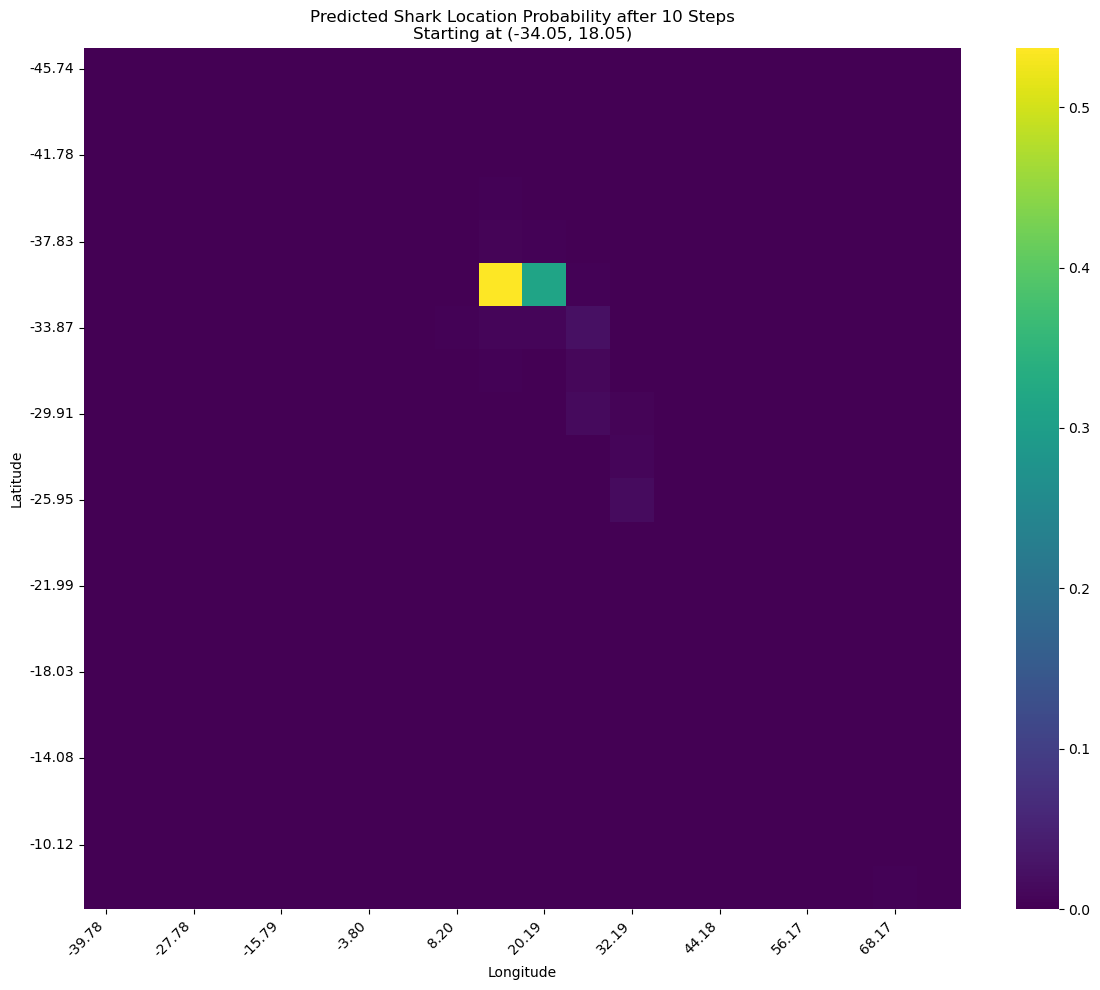

In [ ]:
# === INPUT YOUR PARAMETERS HERE ===
START_LAT = -34.05
START_LON = 18.05
TIME_STEPS = 10 # Predict time steps (e.g., days) into the future
# ==================================

grid_parameters = (min_lat, min_lon, lat_step, lon_step, GRID_SIZE)

# Run the prediction function
future_probabilities = predict_location_at_time(START_LAT, START_LON, TIME_STEPS, P, grid_parameters) #outputs vt which is a (1 x k) dimensional row vector

# Only proceed if the prediction was successful
if future_probabilities is not None:
    # Reshape the 1D probability vector back into a 2D grid for plotting
    prediction_grid = future_probabilities.reshape((GRID_SIZE, GRID_SIZE))
    
    # Create the heatmap visualization
    plt.figure(figsize=(12, 10))
    sns.heatmap(prediction_grid, cmap='viridis', annot=False)
    
    # Create clear labels for the axes
    tick_positions = np.arange(0, GRID_SIZE, max(1, GRID_SIZE // 10))
    lat_labels = [f"{min_lat + i * lat_step:.2f}" for i in tick_positions]
    lon_labels = [f"{min_lon + i * lon_step:.2f}" for i in tick_positions]

    plt.xticks(ticks=tick_positions + 0.5, labels=lon_labels, rotation=45, ha="right")
    plt.yticks(ticks=tick_positions + 0.5, labels=lat_labels, rotation=0)

    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title(f"Predicted Shark Location Probability after {TIME_STEPS} Steps\nStarting at ({START_LAT}, {START_LON})")
    plt.tight_layout()
    
    # Save the plot to a file
    filename = f"time_specific_hotspot_{TIME_STEPS}_steps.png"
    plt.savefig(filename)
    
    print(f"\nTime-specific prediction visualization saved as '{filename}'")
    top_5_indices = np.argsort(future_probabilities)[-5:][::-1]

    # Print a text summary of the top 5 most likely locations 
    print(f"\nTop 5 most likely grid cells after {TIME_STEPS} steps:")
    for i in top_5_indices:
        row = i // GRID_SIZE
        col = i % GRID_SIZE
        print(f"  - State {i} (Row: {row}, Col: {col}): {future_probabilities[i]:.2%} probability")


# Steady State Vector

The steady-state vector, π, represents the long-term equilibrium probability distribution of the system. It describes where the shark is most likely to be found after a very large number of time steps, regardless of its starting position.

The vector is defined as the unique probability vector that satisfies the eigenvector equation:

$$ \pi P = \pi $$

This means that once the system reaches this distribution, it no longer changes. In practice, π is calculated by finding the limit of the powered transition matrix. As t→∞, all rows of the matrix P 
t
  converge to the steady-state vector π:

$$ \lim_{t \to \infty} P^t = \begin{bmatrix} \pi \ \pi \ \vdots \ \pi \end{bmatrix} $$

This vector provides the long-term prediction of shark "hotspots."

Steady-State Vector (π) calculated successfully.

Long-term hotspot visualization saved as 'steady_state_hotspots.png'


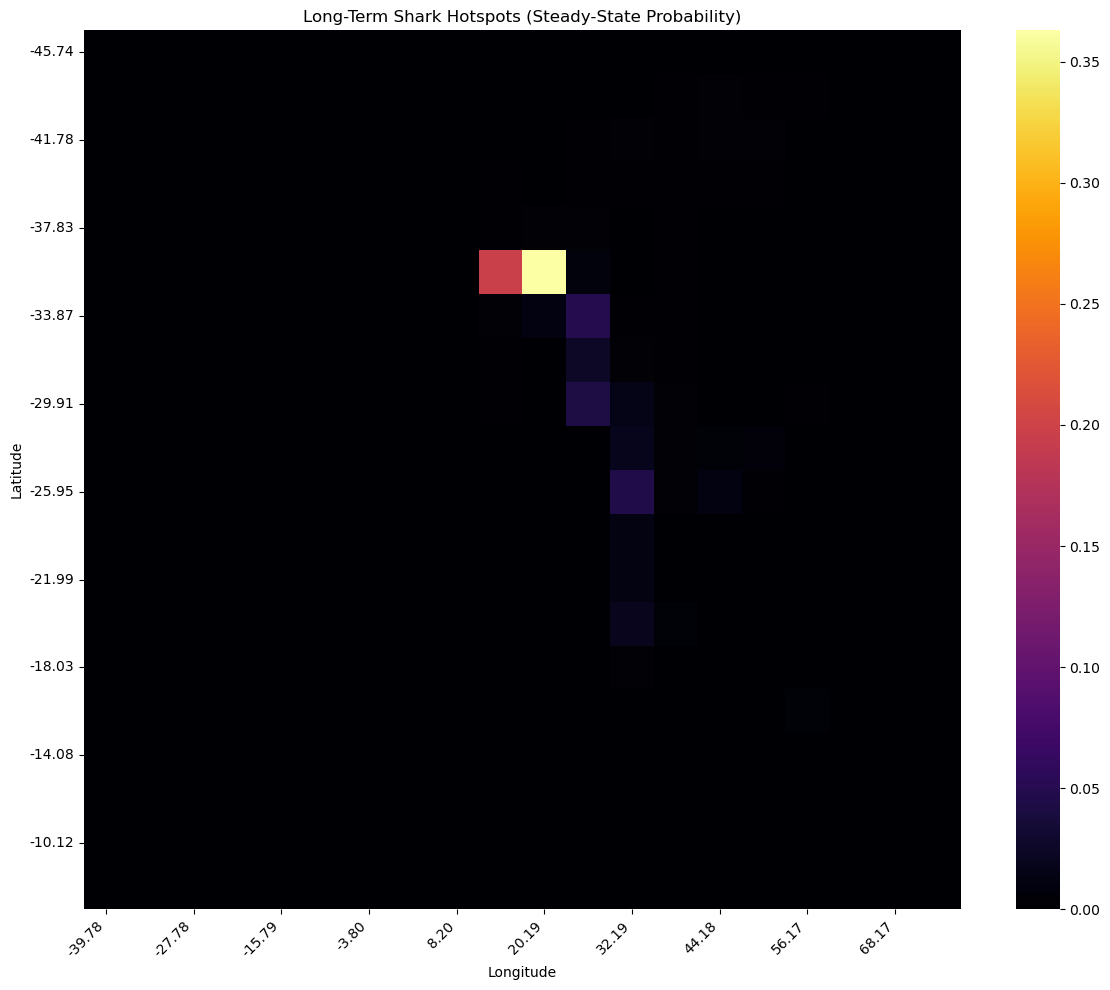

In [14]:
import sys

time = sys.maxsize ##
##Exploring larger numbers (e.g. 10000)
time = 100
try:
    # Raise the transition matrix to a high power to find the steady-state
    P_steady = np.linalg.matrix_power(P, time)
    steady_state_vector = P_steady[0]
    print("Steady-State Vector (π) calculated successfully.")

    # Visualize the steady-state heatmap
    steady_state_grid = steady_state_vector.reshape((GRID_SIZE, GRID_SIZE))
    plt.figure(figsize=(12, 10))
    sns.heatmap(steady_state_grid, cmap='inferno', annot=False)
    
    tick_positions = np.arange(0, GRID_SIZE, max(1, GRID_SIZE // 10))
    lat_labels = [f"{min_lat + i * lat_step:.2f}" for i in tick_positions]
    lon_labels = [f"{min_lon + i * lon_step:.2f}" for i in tick_positions]
    plt.xticks(ticks=tick_positions + 0.5, labels=lon_labels, rotation=45, ha="right")
    plt.yticks(ticks=tick_positions + 0.5, labels=lat_labels, rotation=0)
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title("Long-Term Shark Hotspots (Steady-State Probability)")
    plt.tight_layout()
    plt.savefig("steady_state_hotspots.png")
    print("\nLong-term hotspot visualization saved as 'steady_state_hotspots.png'")

except np.linalg.LinAlgError:
    print("\nCould not compute steady-state vector. The model may be too sparse.")

# Main Predictive Model

Compulsory Arguments: GRID_SIZE , START_LAT, START_LON, TIME_STEPS
Accepts optional arguments: sex and maturity

In [ ]:
def run_prediction_model(GRID_SIZE , START_LAT, START_LON, TIME_STEPS, sex=None, maturity=None):
    """
    Loads the standardized daily data, optionally filters it by sex and/or maturity, and runs predictions.

    Args:
        GRID_SIZE (int): The resolution of the grid (e.g., 20 for a 20x20 grid).
        START_LAT (float): The starting latitude for the time-specific prediction.
        START_LON (float): The starting longitude for the time-specific prediction.
        TIME_STEPS (int): The number of future time steps (days) to predict.
        sex (str, optional): The sex to model ('M' or 'F'). Defaults to None.
        maturity (str, optional): The maturity level to model. Defaults to None.
    """
    # --- Error Handling for Compulsory Arguments ---
    if any(arg is None for arg in [GRID_SIZE, START_LAT, START_LON, TIME_STEPS]):
        print("CRITICAL ERROR: GRID_SIZE, START_LAT, START_LON, and TIME_STEPS are required arguments.")
        return

    # --- 1. Load the  standardized data file ---
    input_filename = "standardized_shark_data_daily.csv"
    try:
        df = pd.read_csv(input_filename)
        print(f"Successfully loaded '{input_filename}'.")
    except FileNotFoundError:
        print(f"\n--- ERROR ---")
        print(f"Required preprocessed file '{input_filename}' not found.")
        print("Please run the 'standardize_data.py' script first to generate this file.")
        print("Skipping this prediction run.\n")
        return

    # --- 2. Filter Data Internally Based on Arguments ---
    filter_description_parts = []
    if sex:
        df = df[df['sex'].str.upper() == sex.upper()]
        filter_description_parts.append(f"Sex={sex.upper()}")
    if maturity:
        df = df[df['maturity'].str.contains(maturity, case=False, na=False)]
        filter_description_parts.append(f"Maturity={maturity}")
    
    if not df.empty:
        print(f"Running model for: {', '.join(filter_description_parts) if filter_description_parts else 'All Sharks'}")
        print(f"Using {len(df)} data points.")
    else:
        print(f"No data found for filters: {', '.join(filter_description_parts)}. Halting this run.")
        return

    # --- 3. Foundational Model Setup ---
    NUM_STATES = GRID_SIZE * GRID_SIZE #Uses Global Variable GRID_SIZE

    min_lat, max_lat = df['latitude'].min(), df['longitude'].max()
    min_lon, max_lon = df['longitude'].min(), df['longitude'].max()

    lat_step = (max_lat - min_lat) / GRID_SIZE if (max_lat - min_lat) > 0 else 1
    lon_step = (max_lon - min_lon) / GRID_SIZE if (max_lon - min_lon) > 0 else 1

    df['state'] = df.apply(lambda row: get_state(row['latitude'], row['longitude'], min_lat, min_lon, lat_step, lon_step, GRID_SIZE), axis=1)

    transition_counts = np.zeros((NUM_STATES, NUM_STATES))
    for i in range(1, len(df)):
        if df['deployid'].iloc[i] == df['deployid'].iloc[i-1]:
            prev_state = df['state'].iloc[i-1]
            current_state = df['state'].iloc[i]
            transition_counts[prev_state, current_state] += 1

    P = np.zeros_like(transition_counts)
    row_sums = transition_counts.sum(axis=1)
    non_zero_rows = row_sums > 0
    P[non_zero_rows] = transition_counts[non_zero_rows] / row_sums[non_zero_rows, np.newaxis]
    print("Transition Matrix (P) built successfully for this subgroup.")

    # --- 4. Steady-State Prediction ---
    try:
        P_steady = np.linalg.matrix_power(P, 100)
        steady_state_vector = P_steady[0]
        
        steady_state_grid = steady_state_vector.reshape((GRID_SIZE, GRID_SIZE))
        plt.figure(figsize=(12, 10))
        sns.heatmap(steady_state_grid, cmap='inferno', annot=False)
        
        tick_positions = np.arange(0, GRID_SIZE, max(1, GRID_SIZE // 10))
        lat_labels = [f"{min_lat + i * lat_step:.2f}" for i in tick_positions]
        lon_labels = [f"{min_lon + i * lon_step:.2f}" for i in tick_positions]
        plt.xticks(ticks=tick_positions + 0.5, labels=lon_labels, rotation=45, ha="right")
        plt.yticks(ticks=tick_positions + 0.5, labels=lat_labels, rotation=0)
        plt.xlabel("Longitude")
        plt.ylabel("Latitude")
        plt.title(f"Long-Term Hotspots ({', '.join(filter_description_parts) if filter_description_parts else 'All Sharks'})")
        plt.tight_layout()
        
        # Dynamic output filename for steady-state plot
        output_suffix = "_".join(part.split('=')[1] for part in filter_description_parts) or "all"
        ss_filename = f"steady_state_hotspots_{output_suffix}.png"
        plt.savefig(ss_filename)
        print(f"Long-term hotspot visualization saved as '{ss_filename}'")

    except np.linalg.LinAlgError:
        print("Could not compute steady-state vector for this subgroup.")

    # --- 5. Time-Specific Prediction ---
    grid_parameters = (min_lat, min_lon, lat_step, lon_step, GRID_SIZE)
    future_probabilities = predict_location_at_time(START_LAT, START_LON, TIME_STEPS, P, grid_parameters)

    if future_probabilities is not None:
        prediction_grid = future_probabilities.reshape((GRID_SIZE, GRID_SIZE))
        
        plt.figure(figsize=(12, 10))
        sns.heatmap(prediction_grid, cmap='viridis', annot=False)
        
        tick_positions = np.arange(0, GRID_SIZE, max(1, GRID_SIZE // 10))
        lat_labels = [f"{min_lat + i * lat_step:.2f}" for i in tick_positions]
        lon_labels = [f"{min_lon + i * lon_step:.2f}" for i in tick_positions]
        plt.xticks(ticks=tick_positions + 0.5, labels=lon_labels, rotation=45, ha="right")
        plt.yticks(ticks=tick_positions + 0.5, labels=lat_labels, rotation=0)
        plt.xlabel("Longitude")
        plt.ylabel("Latitude")
        plt.title(f"Predicted Location after {TIME_STEPS} Days ({', '.join(filter_description_parts) if filter_description_parts else 'All Sharks'})")
        plt.tight_layout()
        
        ts_filename = f"time_specific_{TIME_STEPS}_days_{output_suffix}.png"
        plt.savefig(ts_filename)
        print(f"Time-specific prediction saved as '{ts_filename}'")

        top_5_indices = np.argsort(future_probabilities)[-5:][::-1]
        print(f"\nTop 5 most likely grid cells after {TIME_STEPS} days:")
        for i in top_5_indices:
            row = i // GRID_SIZE
            col = i % GRID_SIZE
            print(f"  - State {i} (Row: {row}, Col: {col}): {future_probabilities[i]:.2%} probability")





--- RUN 1: Processing ALL sharks ---
Successfully loaded 'standardized_shark_data_daily.csv'.
Running model for: All Sharks
Using 4752 data points.
Transition Matrix (P) built successfully for this subgroup.
Long-term hotspot visualization saved as 'steady_state_hotspots_all.png'
Time-specific prediction saved as 'time_specific_10_days_all.png'

Top 5 most likely grid cells after 10 days:
  - State 29 (Row: 1, Col: 9): 53.33% probability
  - State 30 (Row: 1, Col: 10): 31.88% probability
  - State 51 (Row: 2, Col: 11): 3.01% probability
  - State 31 (Row: 1, Col: 11): 2.25% probability
  - State 72 (Row: 3, Col: 12): 2.04% probability

--- RUN 2: Processing only ADULT FEMALES ---
Successfully loaded 'standardized_shark_data_daily.csv'.
Running model for: Sex=F, Maturity=Adult
Using 1991 data points.
Transition Matrix (P) built successfully for this subgroup.
Long-term hotspot visualization saved as 'steady_state_hotspots_F_Adult.png'
Time-specific prediction saved as 'time_specific_10_

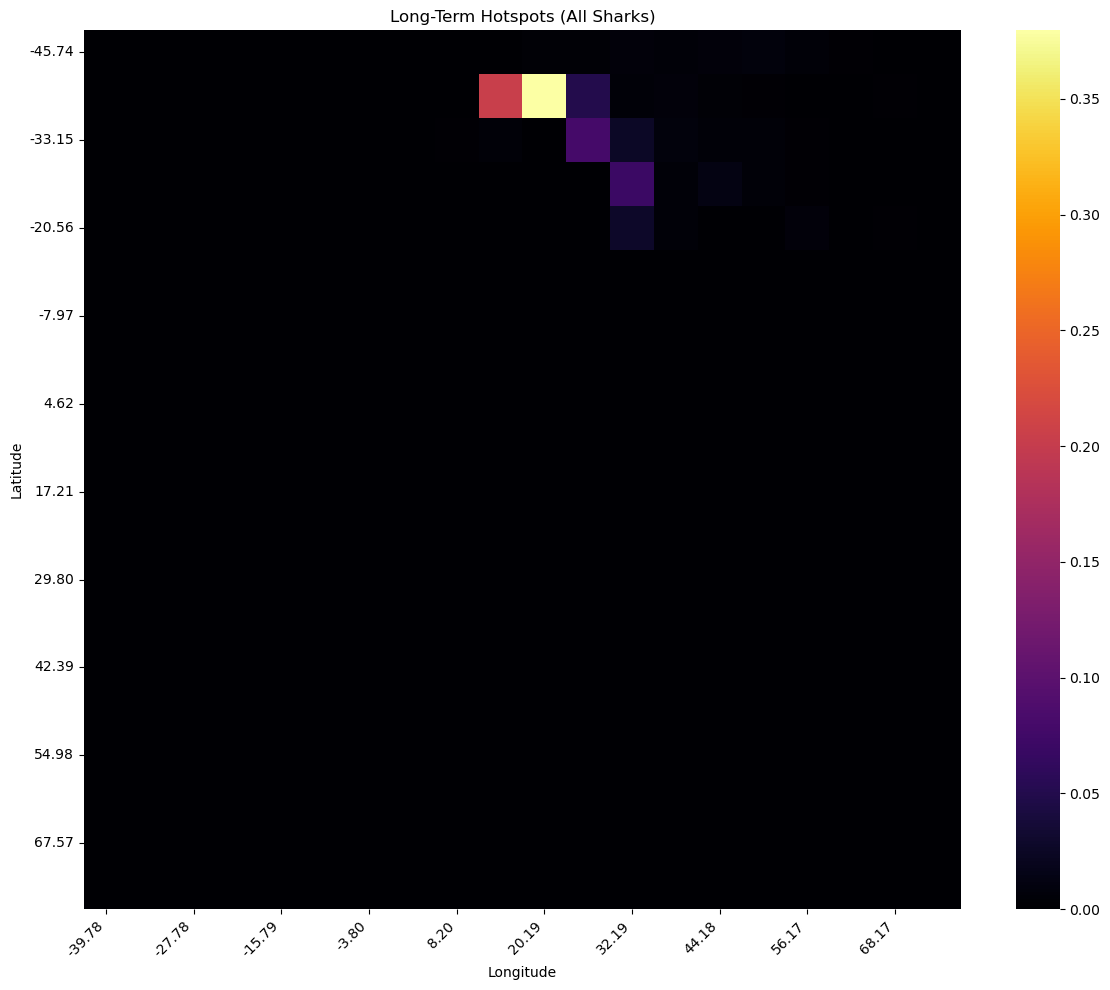

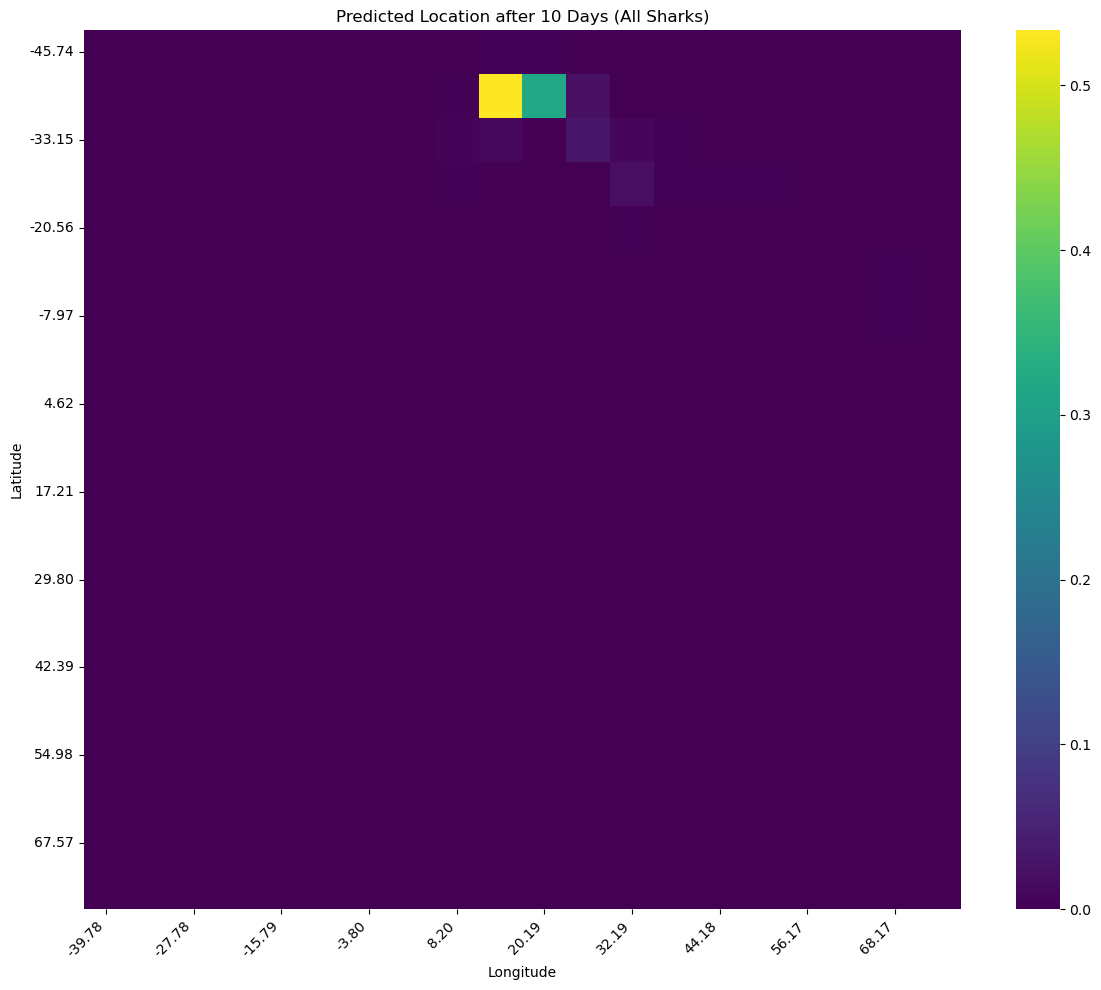

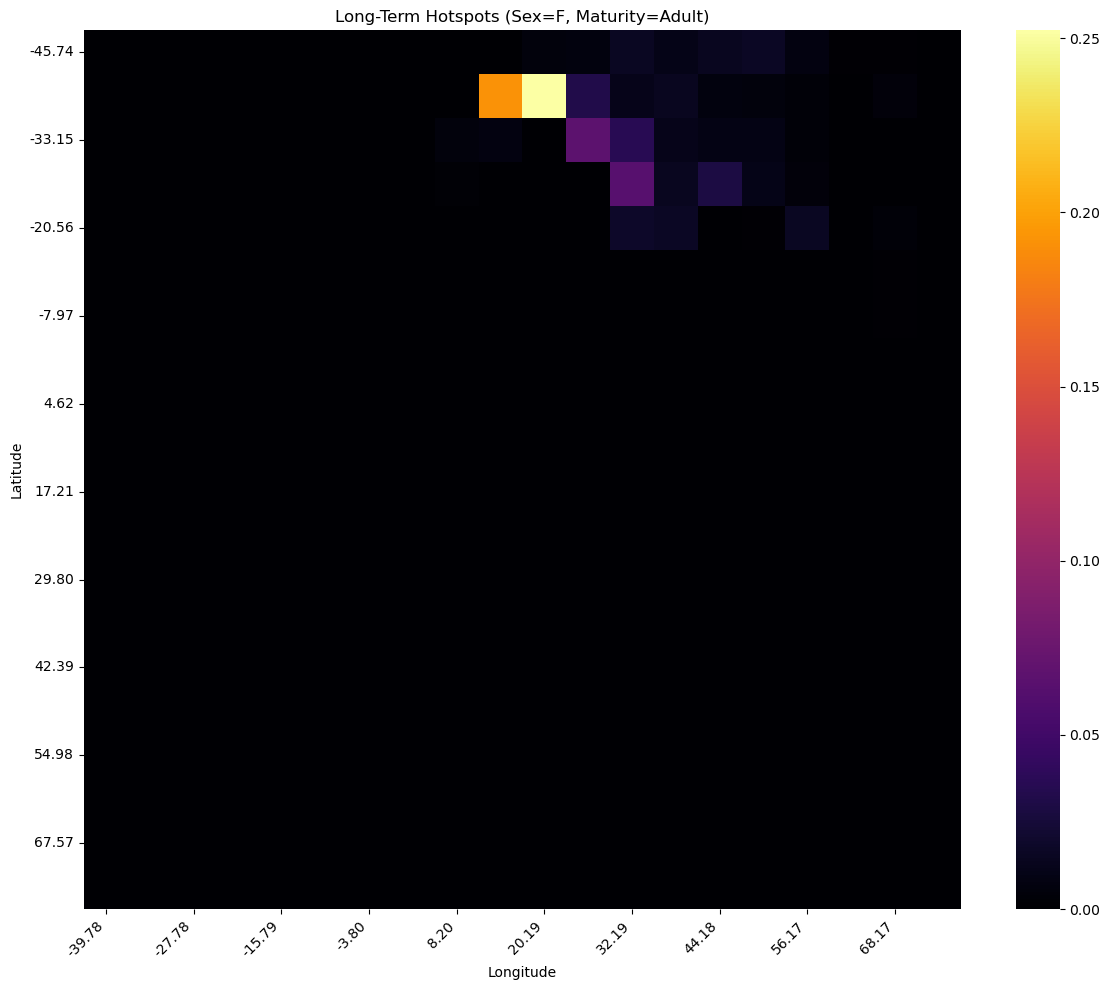

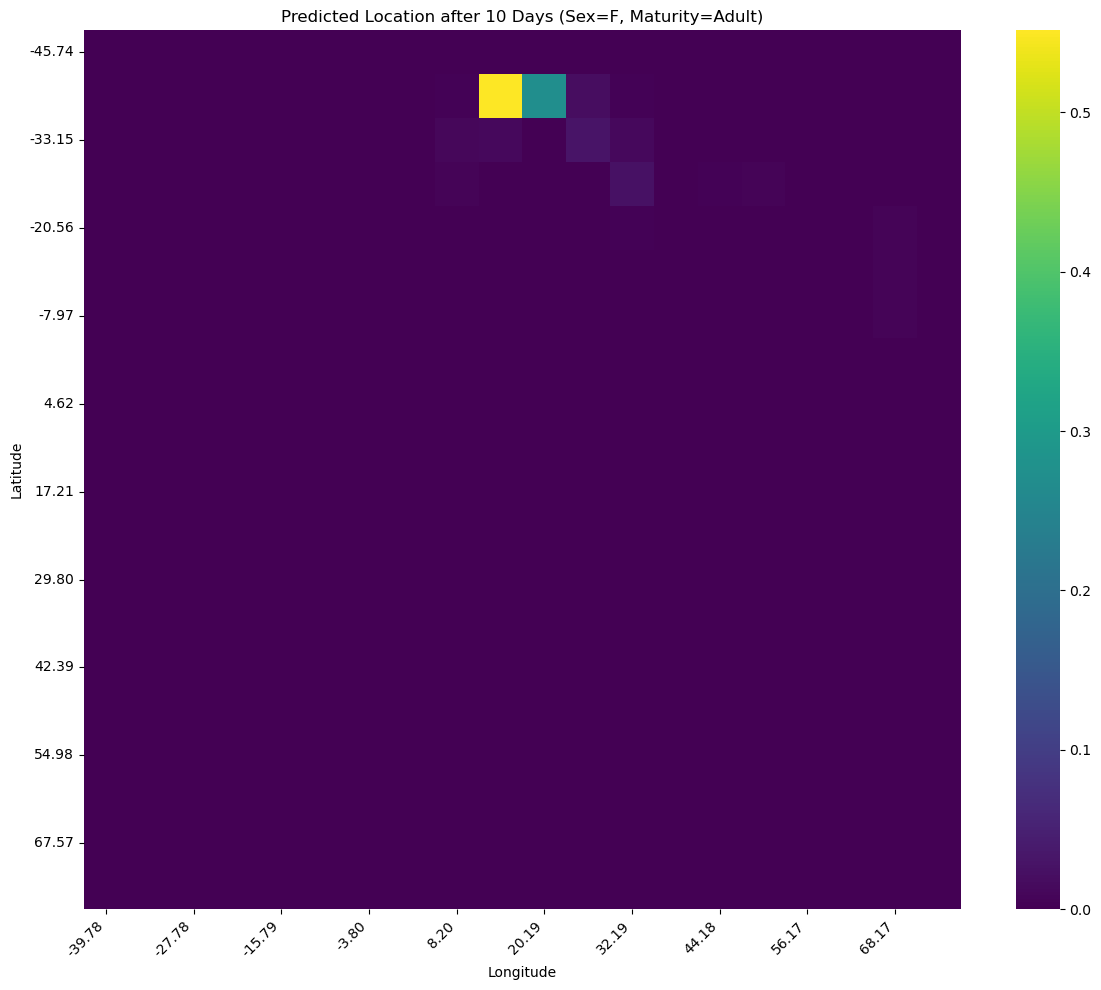

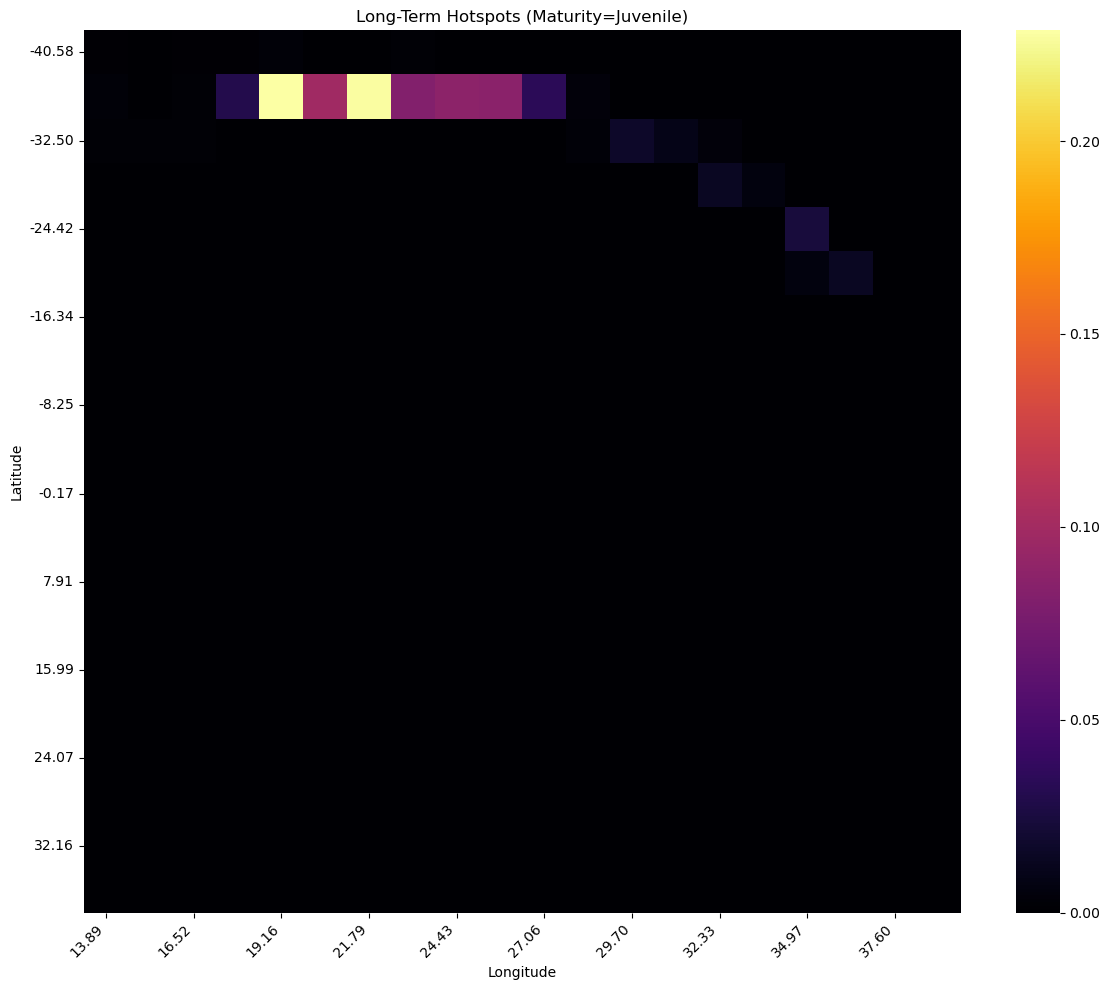

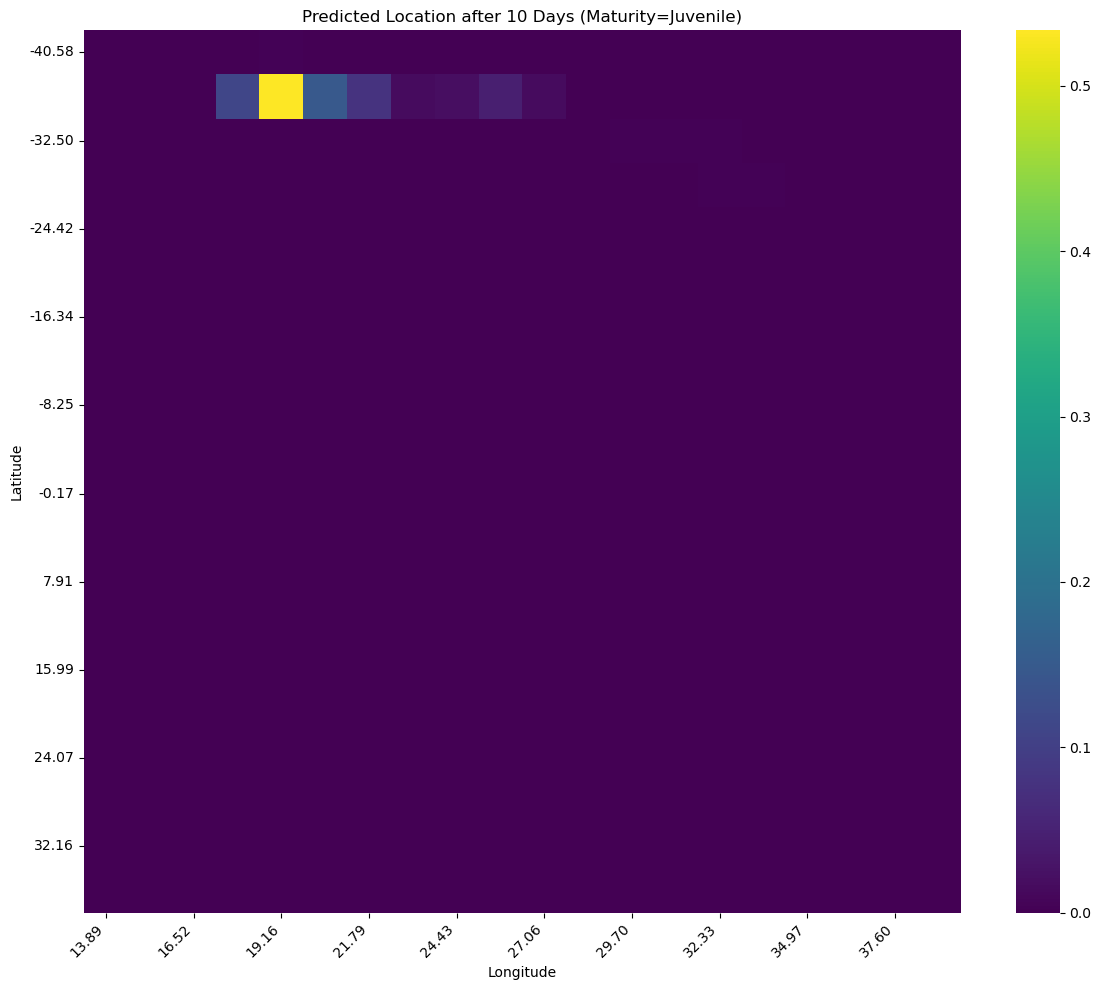

In [ ]:
# --- Execute the function with different filters ---
if __name__ == "__main__":
    # Run 1: Model for ALL sharks
    print("--- RUN 1: Processing ALL sharks ---")
    run_prediction_model(GRID_SIZE = 20, START_LAT = -34.05, START_LON = 18.05, TIME_STEPS = 10)

    # Run 2: Model for only ADULT FEMALES
    print("\n--- RUN 2: Processing only ADULT FEMALES ---")
    run_prediction_model(GRID_SIZE = 20, START_LAT = -34.05, START_LON = 18.05, TIME_STEPS = 10, sex='F', maturity='Adult')

    # Run 3: Model for only JUVENILE sharks
    print("\n--- RUN 3: Processing only JUVENILE sharks ---")
    run_prediction_model(GRID_SIZE = 20, START_LAT = -34.05, START_LON = 18.05, TIME_STEPS = 10, maturity='Juvenile')